# [XXIII Simpósio em Sistemas Computacionais de Alto Desempenho](https://wscad.ufsc.br/)

## OneAPI: Uma Abordagem para a Computação Heterogênea Centrada no Desenvolvedor

### [Ricardo Menotti](mailto:menotti@ufscar.br) e [Tiago da Conceição Oliveira](mailto:tiago.conceicao@fieb.org.br )

## Otimizações de grão fino (SIMD)

<img src="vector_registers.png">

Antes de entrar no paralelismo de _threads_, principal abordagem da oneAPI para CPUs e GPUs, vamos abordar algumas otimizações de grão fino, das quais muitas delas podem ser obtidas sem qualquer modificação no código. O compilador `dpcpp` foi desenvolvido com base no `llvm` e, portanto, suporta as mesmas otimizações dele. 

A seguir vamos examinar a CPU disponível, seu conjunto de instruções e a capacidade dos compiladores para gerar código usando estas instruções. 

In [1]:
#CPU flag detection
!echo "*** Getting CPU flag capabilities and number of cores"
!cat /proc/cpuinfo  | egrep "(flags|model name)" | sort | uniq -c
#Compiler capabilities. -march=native is required!
!echo "*** Getting GCC capabilities"
!gcc -march=native -dM -E - < /dev/null | egrep "SSE|AVX" | sort 

*** Getting CPU flag capabilities and number of cores
     24 flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single pti ssbd mba ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb intel_pt avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local dtherm ida arat pln pts hwp hwp_act_window hwp_epp hwp_pkg_req pku ospke md_clear flush_l1d arch_capabilities
     24 model name	: I

In [5]:
%%writefile autovector.cpp
#pragma GCC optimize("O3")
#pragma GCC optimize("unroll-loops","omit-frame-pointer","inline")
#pragma GCC option("arch=native","tune=native","no-zero-upper")
#pragma GCC target("avx512f")
#include <x86intrin.h>
#include <bits/stdc++.h>

using namespace std;
using namespace std::chrono;

int main()
{
	const int N = 200000; //Array Size
	const int noTests = 10000; //Number of tests
	float a[N],b[N],c[N],result[N];
	auto now = high_resolution_clock::now();
	for (int i = 0; i < N; ++i)  //Data initialization
	{ 
	  a[i] =       ((float)i)+ 0.1335f; 
	  b[i] = 1.50f*((float)i)+ 0.9383f; 
	  c[i] = 0.33f*((float)i)+ 0.1172f; 
	}    
	for (int i = 0; i < noTests; ++i) 
	  for (int j = 0; j < N; ++j)
	  {
	    result[j] = a[j]+b[j]-c[j]+3*(float)i;
	  }
	auto end_time = duration_cast<duration<double>>(high_resolution_clock::now() - now).count();
	assert( result[2] == ( 2.0f + 0.1335f)+( 1.50f*2.0f + 0.9383f)-(0.33f*2.0f+0.1172f)+3*(float)(noTests-1));
	cout << "Time used: "<< end_time << "s, N * noTests="<<(N*noTests)<< endl;
	return 0;
}

Overwriting autovector.cpp


In [6]:
!g++ -S autovector.cpp -fverbose-asm
!grep mm autovector.s

# -fassume-phsa -fasynchronous-unwind-tables -fauto-inc-dec -fcommon
# -mglibc -mieee-fp -mlong-double-80 -mmmx -mno-sse4 -mpush-args -mred-zone
	.comm	_ZStL8__ioinit,1,1
	vmovdqa64	.LC0(%rip), %zmm1	#, vect_vec_iv_.51
	vmovaps	.LC2(%rip), %zmm7	#, tmp145
	vmovaps	.LC5(%rip), %zmm4	#, tmp148
	vmovaps	.LC6(%rip), %zmm3	#, tmp138
	vmovdqa64	%zmm1, %zmm0	# vect_vec_iv_.51, vect_vec_iv_.51
	vmovaps	.LC3(%rip), %zmm6	#, tmp146
	vmovaps	.LC4(%rip), %zmm5	#, tmp147
	vcvtdq2ps	%zmm0, %zmm0	# vect_vec_iv_.51, vect__1.52
	vaddps	%zmm7, %zmm0, %zmm2	# tmp145, vect__1.52, vect__2.53
	vmovdqa64	.LC1(%rip), %zmm8	#, tmp144
	vpaddd	%zmm8, %zmm1, %zmm1	# tmp144, vect_vec_iv_.51, vect_vec_iv_.51
	vmovaps	%zmm2, (%r8)	# vect__2.53, MEM[symbol: a, index: ivtmp.88_92, offset: 0B]
	vmovaps	%zmm0, %zmm2	# vect__1.52, vect__4.57
	vfmadd132ps	%zmm4, %zmm3, %zmm0	# tmp148, tmp138, vect__6.61
	vfmadd132ps	%zmm6, %zmm5, %zmm2	# tmp146, tmp147, vect__4.57
	vmovaps	%zmm0, (%rdi)	# vect__6.61, MEM[symbol: c, index:

In [7]:
!g++ -o autovector autovector.cpp && ./autovector

Time used: 0.202079s, N * noTests=2000000000


In [9]:
!dpcpp -S autovector.cpp -fverbose-asm
!grep mm autovector.s

Binary file autovector.s matches


In [ ]:
!dpcpp -o autovector autovector.cpp && autovector

,versão,tempo_de_execução_s
0,naive,4.318750
1,o3,1.090910
2,unroll,0.208338
3,avx512f,0.197168


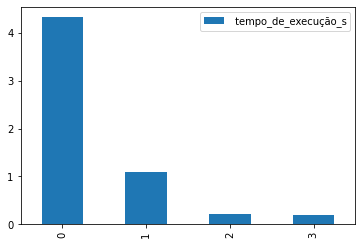

In [13]:
# Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
import pandas as pd
import numpy

df = pd.read_csv('data.csv')
plt = df.plot(kind="bar")
df

## Conceitos básicos

### Buffers e accessors
```cpp
#include <CL/sycl.hpp>
#include <array>
#include <iostream>
#include <string>

#define array_size 10000

using namespace sycl;

int main(int argc, char* argv[]) {
    default_selector selector;
    try {
        queue q(selector);
        std::array<int, array_size> a, b, s; 
        std::cout << "Running on device: " << q.get_device().get_info<info::device::name>() << "\n";
        {
            buffer a_buf(a);
            buffer b_buf(b);
            buffer s_buf(s);        
            for (size_t i = 0; i < array_size; i++) {
                a[i] = i;
                b[i] = i;
            }
            range<1> num_items{array_size};
            q.submit([&](handler &h) {
                accessor aa(a_buf, h, read_only);
                accessor ab(b_buf, h, read_only);
                accessor as(s_buf, h, write_only, no_init);        
                h.parallel_for(num_items, [=](auto i) { as[i] = aa[i] + ab[i]; });
            }).wait();
        }
        int indices[]{0, 1, 2, (array_size - 2), (array_size - 1)};
        constexpr size_t indices_size = sizeof(indices) / sizeof(int);
        for (int i = 0; i < indices_size; i++) {
            int j = indices[i];
            if (i == indices_size - 2) 
                std::cout << "...\n";
            std::cout << "[" << j << "]: " << j << " + " << j << " = " << s[j] << "\n";
        }
    } catch (exception const &e) {
        std::cout << "An exception is caught while adding two vectors.\n";
        std::terminate();
    }
    std::cout << "Vector add successfully completed on device.\n";
    return 0;
}
```
### Unified Shared Memory
```cpp
#include <CL/sycl.hpp>
#include <array>
#include <iostream>
#include <string>

#define array_size 10000

using namespace sycl;

int main(int argc, char* argv[]) {
    default_selector selector;
    try {
        queue q(selector);
        int *a = malloc_shared<int>(array_size, q);
        int *b = malloc_shared<int>(array_size, q);
        int *s = malloc_shared<int>(array_size, q);
        std::cout << "Running on device: " << q.get_device().get_info<info::device::name>() << "\n";
        {
            for (size_t i = 0; i < array_size; i++) {
                a[i] = i;
                b[i] = i;
            }
            range<1> num_items{array_size};
            q.submit([&](handler &h) {
                h.parallel_for(num_items, [=](auto i) { s[i] = a[i] + b[i]; });
            }).wait();
        }
        int indices[]{0, 1, 2, (array_size - 2), (array_size - 1)};
        constexpr size_t indices_size = sizeof(indices) / sizeof(int);
        for (int i = 0; i < indices_size; i++) {
            int j = indices[i];
            if (i == indices_size - 2) 
                std::cout << "...\n";
            std::cout << "[" << j << "]: " << j << " + " << j << " = " << s[j] << "\n";
        }
    } catch (exception const &e) {
        std::cout << "An exception is caught while adding two vectors.\n";
        std::terminate();
    }
    free(a, q);
    free(b, q);
    free(s, q);
    std::cout << "Vector add successfully completed on device.\n";
    return 0;
}
```

In [1]:
!diff addvecbuf.cpp addvecusm.cpp

14c14,16
<         std::array<int, array_size> a, b, s; 
---
>         int *a = malloc_shared<int>(array_size, q);
>         int *b = malloc_shared<int>(array_size, q);
>         int *s = malloc_shared<int>(array_size, q);
17,19d18
<             buffer a_buf(a);
<             buffer b_buf(b);
<             buffer s_buf(s);        
26,29c25
<                 accessor aa(a_buf, h, read_only);
<                 accessor ab(b_buf, h, read_only);
<                 accessor as(s_buf, h, write_only, no_init);        
<                 h.parallel_for(num_items, [=](auto i) { as[i] = aa[i] + ab[i]; });
---
>                 h.parallel_for(num_items, [=](auto i) { s[i] = a[i] + b[i]; });
43a40,42
>     free(a, q);
>     free(b, q);
>     free(s, q);


In [ ]:
!dpcpp addvecbuf.cpp -o buf && ./buf
!dpcpp addvecusm.cpp -o usm && ./usm

## Laboratórios

### 1. [Filtro Sobel](lab1/lab1.ipynb)

### 2. [Bitonic Sort](lab2/lab2.ipynb)

### 3. [Transformada de Hough](lab3/lab3.ipynb)

## Referências
- https://tech.io/playgrounds/53858/vetorizacao-sse-avx/
- https://github.com/menotti/sycl-wscad-2022
- https://oneapi.io/